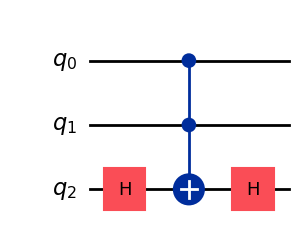

In [16]:


from qiskit import QuantumCircuit

gates_to_apply = [
    ("h", [2]),
    ("ccx", [0, 1, 2]),
    ("h", [2]),
]

def build_oracle(qc, gates):
    """
    Append gates to the given quantum circuit.

    Args:
        qc (QuantumCircuit): The quantum circuit to which gates will be appended.
        methods (list): A list of tuples where each tuple contains a gate name as a string
                        and the parameters for that gate.
                        Example: [("h", [2]), ("ccx", [2, 3, 4]), ("h", [2])]
    """
    for gate_name, args in gates:
        gate = getattr(qc, gate_name)
        gate(*args)

ORACLE_BITS = 3
GROVER_BITS = ORACLE_BITS + 2
oracle = QuantumCircuit(GROVER_BITS)
build_oracle(oracle, gates_to_apply)
oracle.draw("mpl", idle_wires=False)

In [17]:
def phase_oracle(n, gates_to_apply, name="oracle"):
    qc = QuantumCircuit(n, name=name)
    build_oracle(qc, gates_to_apply)
    return qc

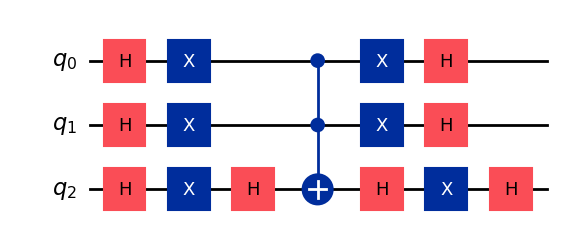

In [18]:
# Function to represent the diffuser part of it
# H, Uf knot mark 000 element in control gate, H gate again
def diffuser(n, gates_to_apply, name="diffuser"):
    qc = QuantumCircuit(n, name=name)

    for qb in range(n - 2):
        qc.h(qb)
    for i in range(n - 2):
        qc.x(i)

    build_oracle(qc, gates_to_apply)

    for i in range(n - 2):
        qc.x(i)
    for qb in range(n - 2):
        qc.h(qb)
    return qc

diffuser(GROVER_BITS, gates_to_apply).draw("mpl", idle_wires=False)



Rounds: 2


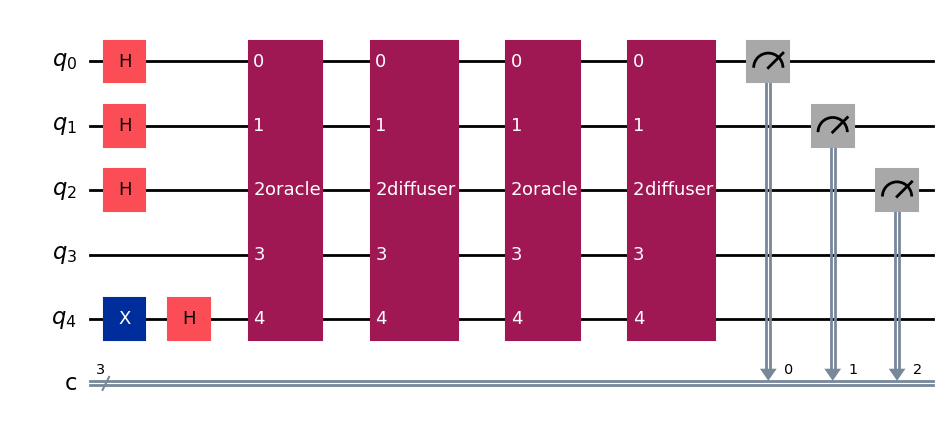

In [19]:
import numpy as np

def search_element(grover_bits, coef_solutions, gates_steps):
    # In the given example, there are three qubit programs,
    # the fourth qubit is the zero qubit reference and fifth one 
    # is to insert the ancilla qubit minus state
    n = grover_bits
    gr = QuantumCircuit(n, n - 2)

    # Number of solutions
    mu = coef_solutions

    rounds = int(np.floor(np.pi / 4 * np.sqrt(2 ** (n - 2)) / mu))
    print(f'Rounds: {rounds}')

    # Step 1: apply Hadamard gates on all working qubits
    gr.h(range(n - 2)) 

    # Put ancilla in minus state |->
    gr.x(n - 1)
    gr.h(n - 1)

    # Step 2: apply r rounds of the phase oracle and the diffuser
    for r in range(rounds):
        gr.append(phase_oracle(n, gates_steps), range(n))
        gr.append(diffuser(n, gates_steps), range(n))

    gr.measure(range(n - 2), range(n - 2))
    display(gr.draw("mpl", idle_wires=False))

    return gr

gates_steps = gates_to_apply
search_element(GROVER_BITS, 1, gates_steps)

In [20]:
import os
from qiskit_aer import Aer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import SamplerPubResult, BitArray
from qiskit.visualization import plot_distribution

def compile_circuit(computer, gr):
    # Optimize for quantum execution
    if (computer.upper() == "CLASSICAL"):
        backend = Aer.get_backend('qasm_simulator')
    else:
        KEY = 'eb84899579603b81353f42fb0a18442ee93c10b17a37039aeb10ca3ad40cc679adae36aaa20d19a2aa0effa9e510e7c962eabd919e3a1915c280d92f30fa4228'

        QiskitRuntimeService.save_account(channel="ibm_quantum",
        								  token=KEY, overwrite=True,
        								  set_as_default=True)
        service = QiskitRuntimeService(channel="ibm_quantum")
        backend = service.least_busy(operational=True, simulator=False)

    target = backend.target
    pass_manager = generate_preset_pass_manager(target=target, optimization_level=3, backend=backend)

    # Transpile it by calling the run method of the pass manager
    transpiled = pass_manager.run(gr)

    # Draw it, excluding idle qubits from the diagram
    display(transpiled.draw("mpl", idle_wires=False, style="iqp", plot_barriers=False))

    sampler = Sampler(mode=backend)

    sampler.options.default_shots = 500

    if (computer.upper() == "QUANTUM"):
        # Turn on dynamical decoupling
        sampler.options.dynamical_decoupling.enable = True
        # Turn on gate twirling. Requires qiskit_ibm_runtime 0.23.0 or later.
        sampler.options.twirling.enable_gates = True

    # Create a job to be executed locally or remote
    job = sampler.run([transpiled])
    # Create histogram from job result
    result = job.result()._pub_results

    if (computer.upper() == "QUANTUM"):
        # If running on a quantum computer
        job_id = job.job_id()
        print(job_id)

    return result

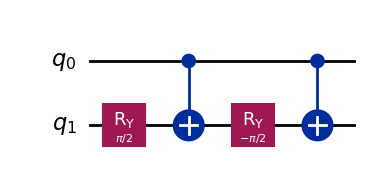

Rounds: 1


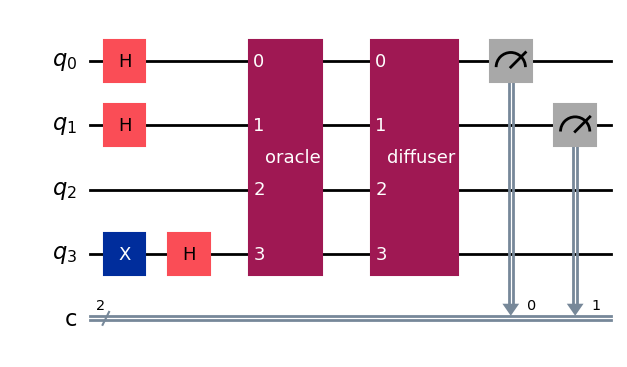

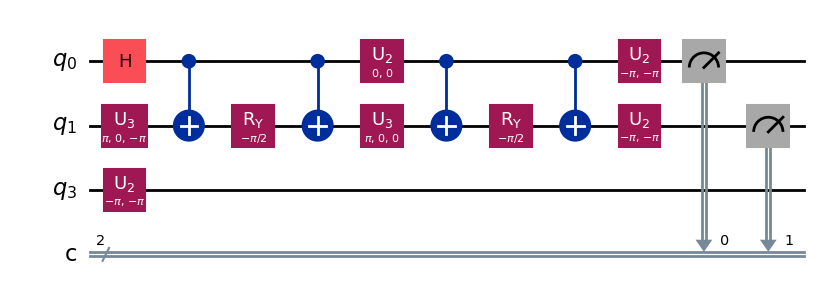

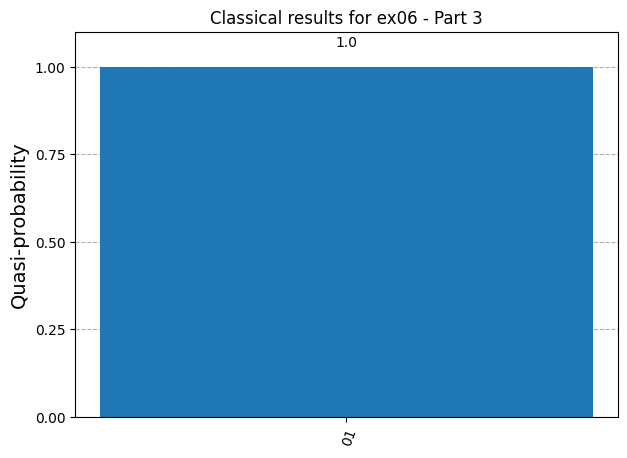

In [22]:
gates_to_apply = [
    ("ry", [np.pi/2, 1]),
    ("cx", [0, 1]),
    ("ry", [-np.pi/2, 1]),
    ("cx", [0, 1]),
]

ORACLE_BITS = 2
GROVER_BITS = ORACLE_BITS + 2
oracle = QuantumCircuit(GROVER_BITS)
build_oracle(oracle, gates_to_apply)
display(oracle.draw("mpl", idle_wires=False))

gr = search_element(GROVER_BITS, 1, gates_to_apply)

# Results for ex06 - Part 3 on a classical computer
result = compile_circuit("CLASSICAL", gr)
plot_data = [SamplerPubResult.join_data(r) for r in result]
counts = [BitArray.get_counts(pd, None) for pd in plot_data]

plot_distribution(counts, title="Classical results for ex06 - Part 3")